In [26]:
#gstat package example

rm(list = ls())
graphics.off()
library(lhs)
library(gstat)
library(sp)

#Problem definition
#Output is 1 if the product of two numbers is larger than 0.75, x1, x2 are both uniformly distributed in [0,1]
Reliability<-function (X) {
  floor(X[ ,1]*X[ ,2]/0.75)
}


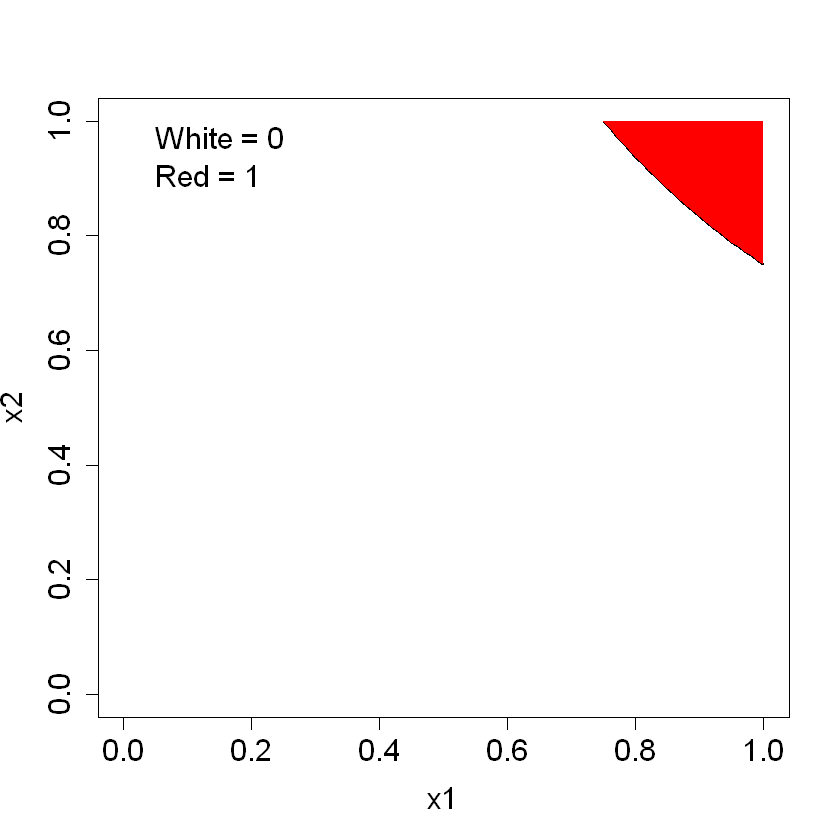

In [27]:
x <- seq(0.75,1,by=0.01)
plot(x,0.75/x,type="l",lwd=2,xlim=c(0,1),ylim=c(0,1),xlab="x1",ylab="x2",cex.lab=1.5,cex.axis=1.5)
polygon(c(0.75,1,rev(x)),c(1,1,rev(0.75/x)),col="red",border = NA)
legend("topleft",legend = c("White = 0", 'Red = 1'),cex = 1.5,bty = "n")

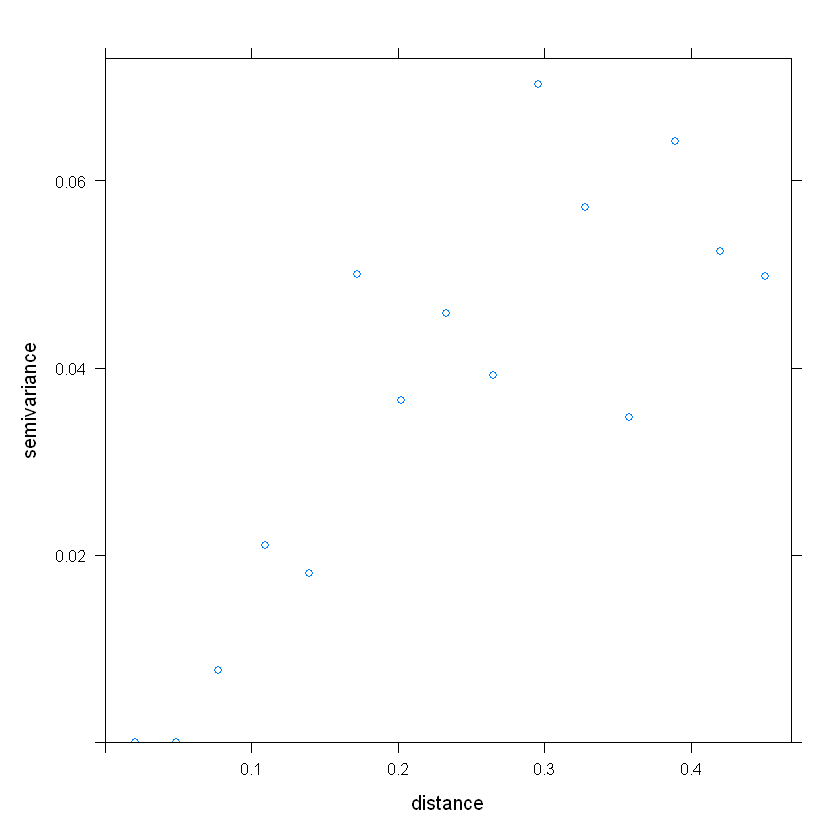

In [28]:
N=5000
n=100
X_all <- data.frame(randomLHS(N,2))
x <- X_all[c(1:n), ]
X <- X_all[c((n+1):N), ]
y <- Reliability(x)
Data <- data.frame(X1=x$X1,X2=x$X2,y=y)
coordinates(Data)=~X1+X2
TheVariogram=variogram(y~1, data=Data)
plot(TheVariogram)

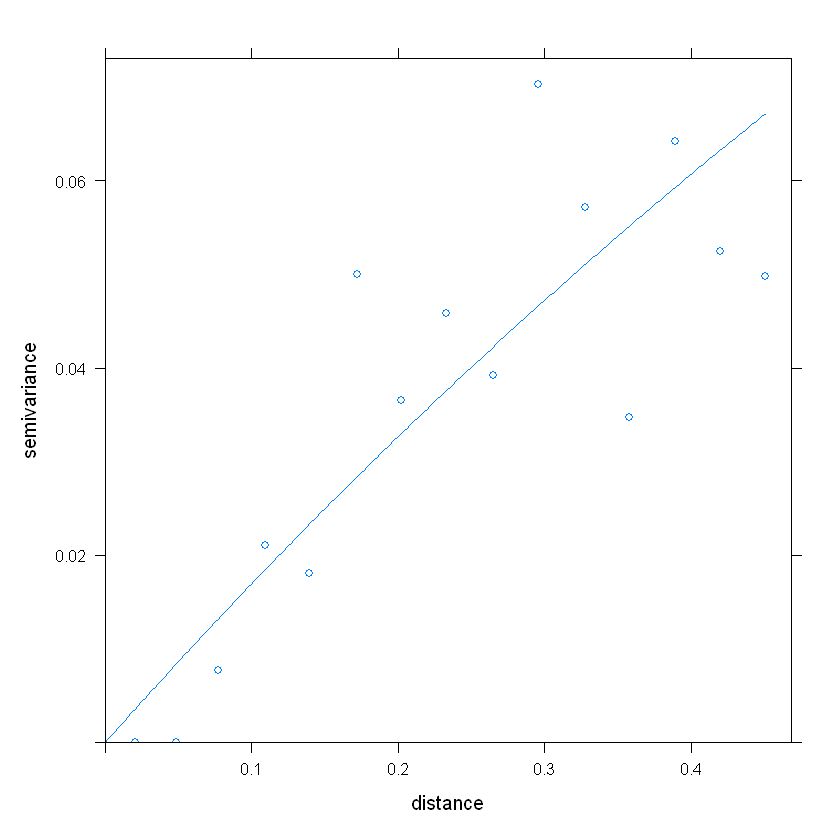

In [29]:
TheVariogramModel <- vgm(psill=0.01, model="Exp", nugget=0.001, range=0.2)
FittedModel <- fit.variogram(TheVariogram, model=TheVariogramModel)
plot(TheVariogram,model=FittedModel)

#Question 1: how to find the best initial values when fitting?

In [30]:
TheGStat <- gstat(id="Rel", formula=y ~ 1, data=Data,model=FittedModel )
level <- seq(0, 1, length=50)
Grid <- expand.grid(X1=level,X2=level)
coordinates(Grid) <- ~ X1+X2
gridded(Grid) <- TRUE
KrigSurface <- predict(TheGStat, model=FittedModel, newdata=Grid)

[using ordinary kriging]


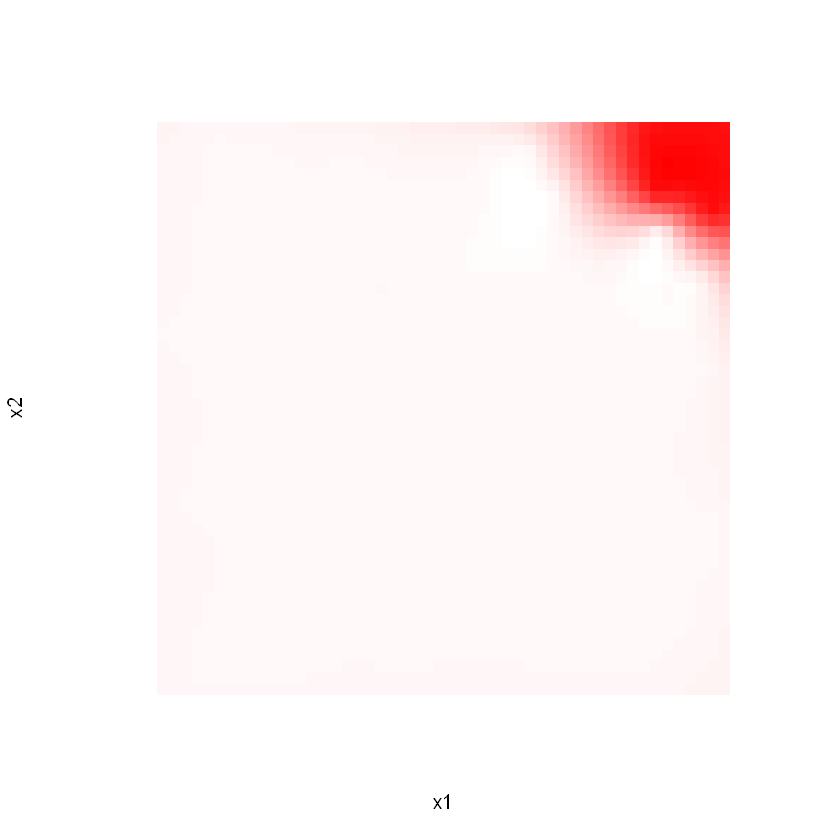

In [31]:
colfunc <- colorRampPalette(c("white", "red"))
cols <- colfunc(100)
image(KrigSurface, col=cols，xlab="x1", ylab="x2")

In [33]:
print(c(max(KrigSurface$Rel.pred),min(KrigSurface$Rel.pred)))

[1]  1.04705634 -0.03258191


In [34]:
#AKMCS
mean <- KrigSurface$Rel.pred
std <- sqrt(KrigSurface$Rel.var)
#Failing probability (percentage of output 1) and learning function
P_fail <- sum(mean>0.5)/N
U <- abs(mean-0.5)/std

#Learning stop criteria:
while ((min(U)<=2) | P_fail==0){
  n <- n+1
  # Learning: choose the point with minimum learning function value as the new sample
  i <- which(U==min(U))
  if (length(i)>1){
    i <- sample(i,1)
  }
  # Fit Gaussian process again
  y <- append(y,Reliability(X[i, ]))
  x <- rbind.data.frame(x,X[i, ])
  Data <- data.frame(X1=x$X1,X2=x$X2,y=y)
  coordinates(Data)=~X1+X2
  TheVariogram=variogram(y~1, data=Data)
  TheVariogramModel <- vgm(psill=0.025, model="Exp", nugget=0.001, range=0.5)
  FittedModel <- fit.variogram(TheVariogram, model=TheVariogramModel)
  TheGStat <- gstat(id="Rel", formula=y ~ 1, data=Data,model=FittedModel )
  KrigSurface <- predict(TheGStat, model=FittedModel, newdata=Grid)
  mean <- KrigSurface$Rel.pred
  std <- sqrt(KrigSurface$Rel.var)
  P_fail <- sum(mean>0.5)/N
  U <- abs(mean-0.5)/std
  print(c(n,min(U)))
}
image.plot(level,level, matrix(mean,ncol=50), xlab="x1", ylab="x2", col=cols,cex.lab=1.5,cex.axis=1.5)
points(x$X1[1:n_init],x$X2[1:n_init],pch=20,cex=2)
points(x$X1[(n_init+1):n],x$X2[(n_init+1):n],pch=20,cex=2,col="blue")
lines(level,0.75/level,lwd=2)

[using ordinary kriging]
[1] 101.00000000   0.03926403
[using ordinary kriging]
[1] 102.00000000   0.03885964
[using ordinary kriging]


Warning message in predict.gstat(TheGStat, model = FittedModel, newdata = Grid):
"Covariance matrix singular at location [0,0,0]: skipping..."
Warning message in predict.gstat(TheGStat, model = FittedModel, newdata = Grid):
"Covariance matrix singular at location [0.0204082,0,0]: skipping..."
Warning message in predict.gstat(TheGStat, model = FittedModel, newdata = Grid):
"Covariance matrix singular at location [0.0408163,0,0]: skipping..."
Warning message in predict.gstat(TheGStat, model = FittedModel, newdata = Grid):
"Covariance matrix singular at location [0.0612245,0,0]: skipping..."
Warning message in predict.gstat(TheGStat, model = FittedModel, newdata = Grid):
"Covariance matrix singular at location [0.0816327,0,0]: skipping..."
Warning message in predict.gstat(TheGStat, model = FittedModel, newdata = Grid):
"Covariance matrix singular at location [0.102041,0,0]: skipping..."
Warning message in predict.gstat(TheGStat, model = FittedModel, newdata = Grid):
"Covariance matrix sin

[1] 103  NA


ERROR: Error in while ((min(U) <= 2) | P_fail == 0) {: missing value where TRUE/FALSE needed
